In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.simplefilter(action="ignore")

from statsmodels.stats.weightstats import ttest_ind
from scipy import stats
from sklearn import metrics

%matplotlib inline

## Load Raw Dataset 
---

In [2]:
data = pd.read_stata("dataraw_thesis_redi.dta")
data.sample(5)

,index,sex,respondent,age,marstat,pidlink,ar02b,hhid07,pid07,hhid00,...,km01a,pm24a,pm24b,pm24c,pm24d,pm24e,pm24f,pm24g,pm24h,educ
8308,2227,1,3,21.0,single,306270006,10,3062700,6.0,,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0
3534,3534,1,3,16.0,single,031070002,3,0310700,2.0,0310700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
9804,3723,1,3,17.0,single,212060006,3,2120641,3.0,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
6406,325,0,3,18.0,married,252195204,3,2521952,NaN,,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4184,4184,0,3,16.0,single,127040006,10,1270400,6.0,1270400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


### Adjusting nominal

In [3]:
data["asset_t"] = data[["A_hr1type_t", "E_hr1type_t", "F_hr1type_t"]].sum(axis=1)
data["asset_t1"] = data[["A_hr1type_t1", "E_hr1type_t1", "F_hr1type_t1"]].sum(axis=1)

In [4]:
for i in ["pce_t1", "asset_t1"]:
    data[i] = data[i] / (data["IHK_t1"] /100)
for i in ["pce_t", "asset_t"]:
    data[i] = data[i] / (data["IHK"] / 100)

In [5]:
data["desil_pce_t"] = pd.qcut(data.pce_t, q=10, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
data["desil_asset_t"] = pd.qcut(data.asset_t, q=10, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])

data["desil_pce_t1"] = pd.qcut(data.pce_t1, q=10, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
data["desil_asset_t1"] = pd.qcut(data.asset_t1, q=10, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])

data["quart_pce_t"] =pd.qcut(data.pce_t, q=4, labels=["1", "2", "3", "4"])
data["quart_asset_t"] =pd.qcut(data.asset_t, q=4, labels=["1", "2", "3", "4"])

data["quart_pce_t1"] =pd.qcut(data.pce_t1, q=4, labels=["1", "2", "3", "4"])
data["quart_asset_t1"] =pd.qcut(data.asset_t1, q=4, labels=["1", "2", "3", "4"])

In [6]:
data["asset_t_percap"] = data.asset_t / data["hhsize"]
data["asset_t1_percap"] = data.asset_t1 / data["hhsize"]

In [7]:
def tk01(data):
    if data == 95:
        return 5
    elif data == 2:
        return 3
    elif data == 3:
        return 2
    else:
        return data

In [8]:
data.tk01 = data.tk01.apply(lambda x: tk01(x)) #the ordered

In [9]:
def age(data):
    if data <= 16:
        return 1
    elif data <= 18:
        return 2
    elif data <= 20:
        return 3
    elif data <= 22:
        return 4
    else:
        return 5

In [10]:
data["agegr"] = data["age"].apply(lambda x: age(x))

In [11]:
def hhsize(data):
    if data <= 4:
        return 0
    elif data <= 8:
        return 1
    else:
        return 2

In [12]:
data["hhsizegg"] = data["hhsize"].apply(lambda x: hhsize(x))

In [13]:
for i in data.columns:
    if 95 in (data[i].unique()):
        print (95, i, True)
    elif "95" in (data[i].unique()):
        print ("95", i, True)

95 index True
95 tk16h True
95 us06 True


In [14]:
data.tk16h = data.tk16h.apply(lambda x: np.nan if x in [95, 99] else x)

## Handle Missing Values
---
At first to understand, it doesn’t exist a good way to deal with missing data. Different solutions exist for data imputation which however depends on the kind of problem. Many data are missing because several reason such as the response was out of range, questionable, or not applicable; or respondent refused to answer or didn’t know. So, missing data have several types. First step, we should distinguish between missing at random and not random because of maybe interviewer error. Several methode that can be used for single Imputation, like listwise deletion, central tendency (mean/median/mode), Hot-Cold Deck, nor Regression. ***However, values found in single imputation might be biased by the specific values in the current data set, and not represent the total values of the full population***. This problem can be reduuce with multiple imputation. It metode has a lot of advantages over traditional single imputation methods. Multiple Imputation is an imputation method that works with the assumption that the missing data are missing at Random. The algorithm works by running multiple models and each missing value is modeled conditionally depending on the observed values.

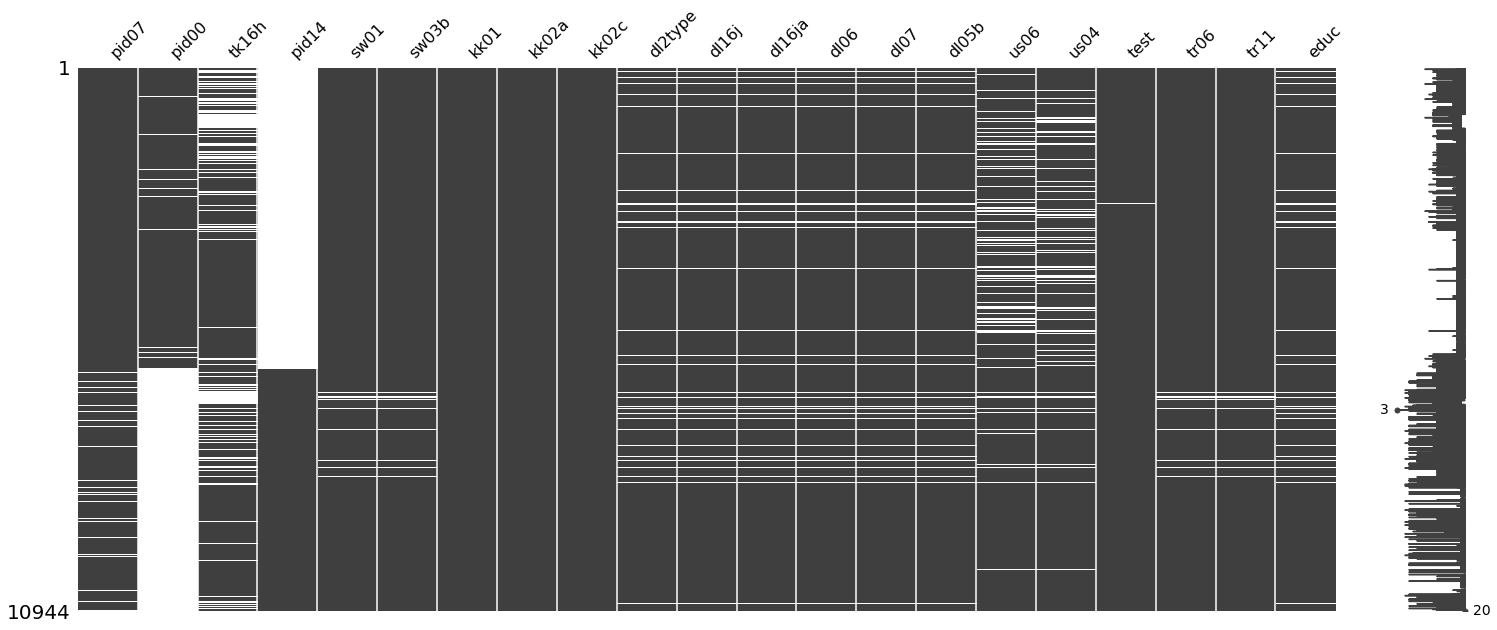

In [15]:
missingdata = data.columns[data.isnull().any()].tolist()
msno.matrix(data[missingdata]);

In [16]:
for i in data.columns:
    if data[i].isnull().sum() > 0:
        print (f"Percenage of missing data in {i} equal to", data[i].isnull().sum()/len(data))

Percenage of missing data in pid07 equal to 0.03289473684210526
Percenage of missing data in pid00 equal to 0.46865862573099415
Percenage of missing data in tk16h equal to 0.22167397660818713
Percenage of missing data in pid14 equal to 0.5556469298245614
Percenage of missing data in sw01 equal to 0.02183845029239766
Percenage of missing data in sw03b equal to 0.02183845029239766
Percenage of missing data in kk01 equal to 0.0014619883040935672
Percenage of missing data in kk02a equal to 0.0024671052631578946
Percenage of missing data in kk02c equal to 0.0014619883040935672
Percenage of missing data in dl2type equal to 0.06186038011695907
Percenage of missing data in dl16j equal to 0.06332236842105263
Percenage of missing data in dl16ja equal to 0.06286549707602339
Percenage of missing data in dl06 equal to 0.06186038011695907
Percenage of missing data in dl07 equal to 0.06186038011695907
Percenage of missing data in dl05b equal to 0.06186038011695907
Percenage of missing data in us06 eq

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [18]:
#create new a random forest model
random_forest = RandomForestClassifier(random_state=101 , 
                                      min_samples_split=25, min_samples_leaf=5,
                                      bootstrap=True, n_estimators=500)

param_grid = { 
    'bootstrap': [True],
    'min_samples_leaf': [5, 6, 7, 8, 9, 10],
    'min_samples_split': [20, 25, 30, 35],
    'n_estimators': [300, 400, 500, 600]
}

#use gridsearch to test all values for n_neighbors
#randomf_gscv = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv= 6)

In [19]:
train_data = data.copy()

In [20]:
train_data.sw01.value_counts(dropna=False)

3.0    5529
4.0    2599
2.0    1859
1.0     455
NaN     239
5.0     208
6.0      36
8.0      18
9.0       1
Name: sw01, dtype: int64

## Categorical

In [21]:
%%time

#fit model to data
col_to_impute = ["sw01", "sw03b", "kk01", "kk02c", "educ", "dl07", "dl05b", 
                 "tk16h", "dl16j", "kk02a", "tr06", "tr11"]
for i in col_to_impute:
    df = train_data[train_data[i].notnull()]
    df1 = train_data[train_data[i].isnull()]
    list_independent = ["pce_t", "A_hr1type_t", "E_hr1type_t", "F_hr1type_t",  "age", "sex", "kabid", "married", "year"]
    X = df[list_independent] #independent variable to predict
    y = df[i]
    random_forest.fit(X, y)
    #predict
    X_test = df1[list_independent]
    df1[i] = random_forest.predict(X_test)
    train_data = pd.concat([df, df1])
    #X_r = dataset[list_independent]
    #y_r = dataset[i]
    random_forest.fit(X, y)
    y_arbit = random_forest.predict(X)
    print ("Score of model in ", i, "is", metrics.accuracy_score(y, y_arbit))

Score of model in  sw01 is 0.7199439514245679
Score of model in  sw03b is 0.7452592246613732
Score of model in  kk01 is 0.7371888726207906
Score of model in  kk02c is 0.7267569546120058
Score of model in  educ is 0.7775396902697964
Score of model in  dl07 is 0.7205610207460796
Score of model in  dl05b is 0.8717249439953249
Score of model in  tk16h is 0.8146278469124207
Score of model in  dl16j is 0.6331089649790265
Score of model in  kk02a is 0.6751854905193735
Score of model in  tr06 is 0.802391852751565
Score of model in  tr11 is 0.7592263851256656
Wall time: 6min 5s


## Continuous

In [22]:
random_forest_1 = RandomForestRegressor(random_state=100 , 
                                      min_samples_split=10, min_samples_leaf=2,
                                      bootstrap=True, n_estimators=500)

col_to_impute = ["test", "us06", "us04"]
for i in col_to_impute:
    df = train_data[train_data[i].notnull()]
    df1 = train_data[train_data[i].isnull()]
    list_independent = ["pce_t", "A_hr1type_t", "E_hr1type_t", "F_hr1type_t", "age", "sex", "kabid", "married", "year"]
    X = df[list_independent] #independent variable to predict
    y = df[i]
    random_forest_1.fit(X, y)
    #predict
    X_test = df1[list_independent]
    df1[i] = np.round(random_forest_1.predict(X_test))
    train_data = pd.concat([df, df1])
    print ("Score of model in ", i, "is", random_forest_1.score(X, y))

Score of model in  test is 0.7050568542545741
Score of model in  us06 is 0.6631029614798125
Score of model in  us04 is 0.6955168787768868


In [23]:
for i in train_data.columns:
    if train_data[i].isnull().sum() > 0:
        print (f"Percenage of missing data in {i} equal to", train_data[i].isnull().sum()/len(train_data))

Percenage of missing data in pid07 equal to 0.03289473684210526
Percenage of missing data in pid00 equal to 0.46865862573099415
Percenage of missing data in pid14 equal to 0.5556469298245614
Percenage of missing data in dl2type equal to 0.06186038011695907
Percenage of missing data in dl16ja equal to 0.06286549707602339
Percenage of missing data in dl06 equal to 0.06186038011695907


|variable|description|
|---|---|
tk01| main acivity
|---|---|
dl02 | Can read an bahasa
dl03| Can write an bahasa  
dl06| highest education attainment
dl05a| first age entered elementary school
dl11d| gratuated?
dl11f| year of graduated OR dropout
|---|---|
si21a | IDR 1,000,000 today or IDR 1,000,000 in 1 year
si21b | IDR 1,000,000 today or IDR 3,000,000 in 1 year
si22b | IDR 1,000,000 today or IDR 4,000,000 in 5 years
|---|---|
sw00| overall subjective welfare right now
sw01| subjective economic status
sw03b| subjective household condition
|---|---|
tr06 | How safe do you consider this village?
tr11 | How religious are you?
|---|---|
km01a | Have you ever had (tobacco habit)?
kk01| subjective overall health condition
kk02a| days missed at primary activity last month
kk02c| Compared health 12 months ago
|---|---|
ar02b| relation with Head Household
sc21x| migration history
pm24 | Did you vote in the most recent election

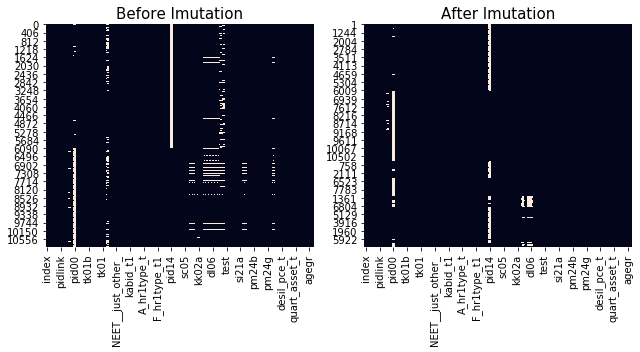

In [24]:
plt.figure(figsize=(9, 5))
plt.subplot(1,2,1)
sns.heatmap(data.isnull(), cbar=False)
plt.title("Before Imutation", size=15)
plt.subplot(1,2,2)
sns.heatmap(train_data.isnull(), cbar=False)
plt.title("After Imutation", size=15)
plt.tight_layout()

## Transform
---

### Made year of schooling

In [25]:
# make year of schooling based on indonesian education system
def year_of_schooling(data):
    if data == 1:
        return 6
    elif data == 2:
        return 9
    elif data == 3:
        return 12
    elif data == 4:
        return 16
    else:
        return np.nan

train_data["educ"] = train_data["educ"].apply(lambda x: year_of_schooling(x))

In [26]:
a = train_data[train_data["dl07"] == 7]
b = train_data[train_data["dl07"] != 7]

In [27]:
#limitation >> dropout in highest grade equal to graduated
# and droput in lowest grade equal to never attain the education

def sdd(data):
    if data == 0:
        return 6
    elif data == 1:
        return 5
    elif data == 2:
        return 4
    elif data == 3:
        return 3
    elif data == 4:
        return 2
    elif data == 5:
        return 1
    else: 
        return 0
    
sd = b[b["educ"] == 6]
sd["grade"] = sd["dl07"].apply(lambda x: sdd(x))
sd["educ"] = sd["educ"] - sd["grade"]

In [28]:
def high_school(data):
    if data == 0:
        return 3
    elif data == 1:
        return 2
    elif data == 2:
        return 1
    else: 
        return 0
    
smp = b[b["educ"] == 9]
smp["grade"] = (smp["dl07"].apply(lambda x: high_school(x)))
smp["educ"] = smp["educ"] - smp["grade"]

sma = b[b["educ"] == 12]
sma["grade"] = (sma["dl07"].apply(lambda x: high_school(x)))
sma["educ"] = sma["educ"] - sma["grade"]

In [29]:
def college(data):
    if data == 0:
        return 4
    elif data == 1:
        return 3
    elif data == 2:
        return 2
    elif data == 3:
        return 1
    else: 
        return 0
    
kuliah = b[b["educ"] == 16]
kuliah["grade"] = kuliah["dl07"].apply(lambda x: college(x))
kuliah["educ"] = kuliah["educ"] - kuliah["grade"]

In [30]:
df = pd.concat([a, sd, smp, sma, kuliah])
df.sample(10)

,index,sex,respondent,age,marstat,pidlink,ar02b,hhid07,pid07,hhid00,...,desil_asset_t1,quart_pce_t,quart_asset_t,quart_pce_t1,quart_asset_t1,asset_t_percap,asset_t1_percap,agegr,hhsizegg,grade
994,994,1,3,17.0,single,078080005,3,0780800,5.0,0780800,...,6,1,2,3,3,4.718261e+06,6.493859e+06,2,1,NaN
7687,1606,0,3,21.0,divorced,178110006,3,1781100,6.0,,...,7,3,1,3,3,4.333549e+06,8.816122e+06,4,1,NaN
2142,2142,1,3,15.0,single,142213103,3,1422131,3.0,1422131,...,1,1,1,1,1,2.563625e+04,2.564128e+05,1,1,2.0
1214,1214,0,3,24.0,single,318130007,3,3181311,5.0,3181311,...,10,4,4,4,4,2.667986e+07,4.703001e+07,5,2,NaN
3616,3616,0,3,17.0,single,038140008,3,0381400,8.0,0381400,...,7,4,4,3,3,1.093183e+08,1.692477e+07,2,0,2.0
4690,4690,1,3,15.0,single,201200006,3,2012000,6.0,2012000,...,3,1,2,1,1,1.398701e+07,4.243255e+06,1,0,2.0
5367,5367,1,3,19.0,single,283010004,4,2830100,4.0,2830100,...,4,1,2,3,2,7.310141e+06,5.194808e+06,3,1,3.0
7427,1346,1,3,20.0,single,128020005,3,1280200,5.0,,...,6,2,2,1,3,8.959277e+06,8.267718e+06,3,1,2.0
4074,4074,1,3,15.0,single,110160006,3,1101631,2.0,1101631,...,6,2,3,2,3,2.718946e+07,1.384261e+07,1,0,1.0
7220,1139,1,3,17.0,single,084050010,3,0840500,10.0,,...,9,4,4,2,4,7.685507e+07,4.592597e+07,2,0,1.0


In [32]:
df.to_stata("data_thesis_redi.dta")